# 解析で必要となるスキル

## データの準備と確認

In [1]:
# 必要なライブラリのimport
import numpy as np
import pandas as pd
from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_theme()

In [2]:
# CSVファイルのデータを読み込む
data = pd.read_csv('./skills.csv')

# 先頭5行を表示
data.head()

,Total_bill,Tip,Sex,Smoker,Day,Time,Size,Tax
0,16.99,1.01,Female,No,Sun,Dinner,2,1.699
1,10.34,1.66,Male,No,Sun,Dinner,3,1.034
2,21.01,3.50,Male,No,Sun,Dinner,3,2.101
3,23.68,3.31,Male,No,Sun,Dinner,2,2.368
4,24.59,3.61,Female,No,Sun,Dinner,4,2.459


<Axes: xlabel='Tip', ylabel='Count'>

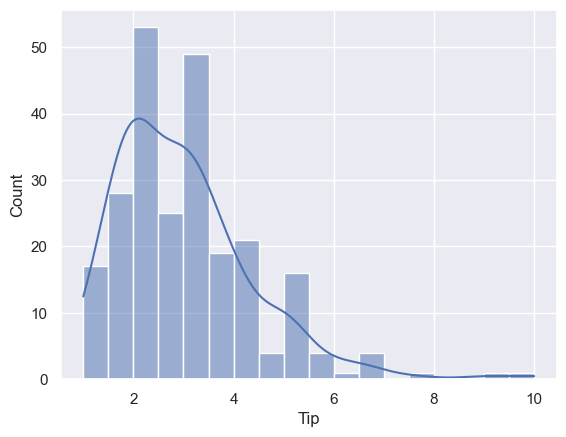

In [3]:
# Tip列のヒストグラムを作成
sns.histplot(data['Tip'], kde=True)

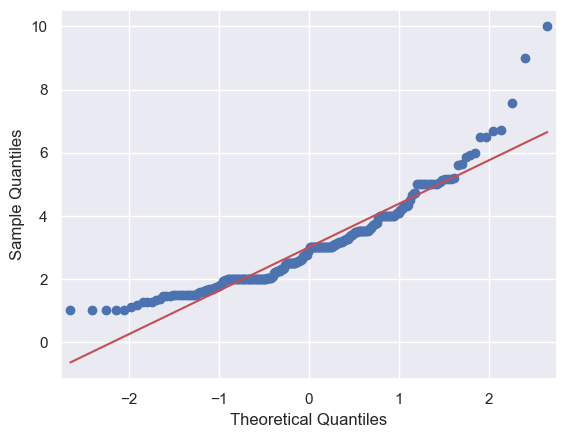

In [4]:
# Q-Qプロットを作成
fig = sm.qqplot(data['Tip'], line = 's')

In [5]:
# 対数変換
data['Tip'] = np.log1p(data['Tip'])

<Axes: xlabel='Tip', ylabel='Count'>

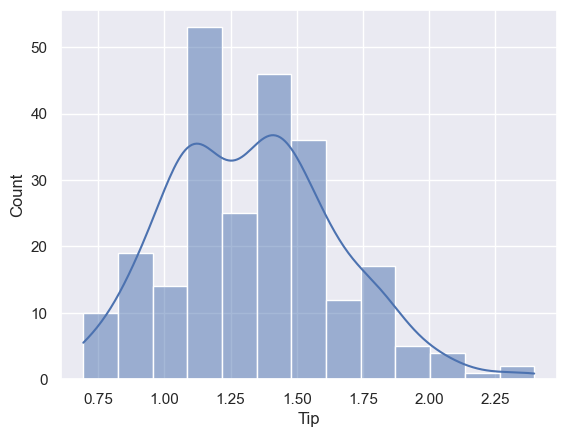

In [6]:
# Tip列のヒストグラムを作成
sns.histplot(data['Tip'], kde=True)

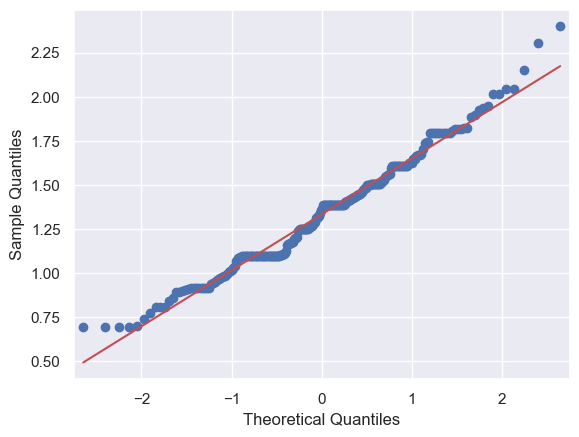

In [7]:
# Q-Qプロットを作成
fig = sm.qqplot(data['Tip'], line = 's')

## 欠損値の扱い方

In [8]:
# 欠損値の数を調べる
col_names = data.columns
for col_name in col_names:
    missing_num = sum(pd.isnull(data[col_name]))
    print(col_name, ': missing record number is', missing_num)

Total_bill : missing record number is 4
Tip : missing record number is 0
Sex : missing record number is 0
Smoker : missing record number is 0
Day : missing record number is 0
Time : missing record number is 0
Size : missing record number is 0
Tax : missing record number is 5


In [9]:
# 顧客のサイズごとに、Total_billの中央値を求める
tb_medians = data.groupby("Size")['Total_bill'].median()
tb_medians

Size
1     7.915
2    15.370
3    20.365
4    25.890
5    29.850
6    32.050
Name: Total_bill, dtype: float64

In [10]:
# 欠損値をグループごとの中央値で埋める
for size in tb_medians.index:
    data.loc[data['Size'] == size, 'Total_bill'] = data.loc[data['Size'] == size, 'Total_bill'].fillna(tb_medians[size])

In [11]:
# 説明変数：Total_bill、応答変数：Taxで線形モデルを作成
lm = smf.ols(formula='Tax ~ Total_bill', data=data).fit()

In [12]:
# 欠損値を線形モデルの予測値で埋める
data['Tax'] = data['Tax'].fillna(lm.predict(data['Total_bill']))

## 相関のある変数の取り扱い

In [13]:
# 相関係数のしきい値を設定
threshold = 0.8

In [14]:
# 相関行列を作成して表示
corr_matrix = data.corr(numeric_only=True).abs()
corr_matrix

,Total_bill,Tip,Size,Tax
Total_bill,1.000000,0.655650,0.599628,0.997713
Tip,0.655650,1.000000,0.488512,0.662105
Size,0.599628,0.488512,1.000000,0.598314
Tax,0.997713,0.662105,0.598314,1.000000


In [15]:
corr_matrix

,Total_bill,Tip,Size,Tax
Total_bill,1.000000,0.655650,0.599628,0.997713
Tip,0.655650,1.000000,0.488512,0.662105
Size,0.599628,0.488512,1.000000,0.598314
Tax,0.997713,0.662105,0.598314,1.000000


In [16]:
# 上三角行列に変換
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper = corr_matrix.where(mask)
upper

,Total_bill,Tip,Size,Tax
Total_bill,NaN,0.65565,0.599628,0.997713
Tip,NaN,NaN,0.488512,0.662105
Size,NaN,NaN,NaN,0.598314
Tax,NaN,NaN,NaN,NaN


In [17]:
# 相関係数がしきい値以上の変数を抽出
to_drop = [column for column in upper.columns if column != 'Tip' if any(upper[column] > threshold)]

print('削除する変数：', to_drop)
print('削除する変数の数：', len(to_drop))

削除する変数： ['Tax']
削除する変数の数： 1


In [18]:
# 相関係数がしきい値以上の変数をdataから削除
data_dropped = data.drop(columns = to_drop)
data_dropped.head()

,Total_bill,Tip,Sex,Smoker,Day,Time,Size
0,16.99,0.698135,Female,No,Sun,Dinner,2
1,10.34,0.978326,Male,No,Sun,Dinner,3
2,21.01,1.504077,Male,No,Sun,Dinner,3
3,23.68,1.460938,Male,No,Sun,Dinner,2
4,24.59,1.528228,Female,No,Sun,Dinner,4


## カテゴリ型の変数とダミー変数

In [19]:
# カテゴリ型の変数をダミー変数化
data_dummied = pd.get_dummies(data_dropped)
data_dummied.head()

,Total_bill,Tip,Size,Sex_Female,Sex_Male,Smoker_No,Smoker_Yes,Day_Fri,Day_Sat,Day_Sun,Day_Thur,Time_Dinner,Time_Lunch
0,16.99,0.698135,2,True,False,True,False,False,False,True,False,True,False
1,10.34,0.978326,3,False,True,True,False,False,False,True,False,True,False
2,21.01,1.504077,3,False,True,True,False,False,False,True,False,True,False
3,23.68,1.460938,2,False,True,True,False,False,False,True,False,True,False
4,24.59,1.528228,4,True,False,True,False,False,False,True,False,True,False


## 訓練データとテストデータ

In [20]:
# 説明変数と応答変数に分ける
X = data_dummied.drop(columns = ['Tip'])
y = data_dummied['Tip']

In [21]:
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2)

## （参考資料）過学習とRidge回帰・Lasso回帰

In [22]:
# λの候補を作成
n_lambda = 50
ridge_lambdas = np.logspace(-10, 1, n_lambda)

In [23]:
# Ridge回帰
model = RidgeCV(cv=10, alphas=ridge_lambdas, fit_intercept=False)
model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-10, 1.67683294e-10, 2.81176870e-10, 4.71486636e-10,
       7.90604321e-10, 1.32571137e-09, 2.22299648e-09, 3.72759372e-09,
       6.25055193e-09, 1.04811313e-08, 1.75751062e-08, 2.94705170e-08,
       4.94171336e-08, 8.28642773e-08, 1.38949549e-07, 2.32995181e-07,
       3.90693994e-07, 6.55128557e-07, 1.09854114e-06, 1.84206997e-06,
       3.08884360e-06, 5.17947468e-0...
       1.93069773e-04, 3.23745754e-04, 5.42867544e-04, 9.10298178e-04,
       1.52641797e-03, 2.55954792e-03, 4.29193426e-03, 7.19685673e-03,
       1.20679264e-02, 2.02358965e-02, 3.39322177e-02, 5.68986603e-02,
       9.54095476e-02, 1.59985872e-01, 2.68269580e-01, 4.49843267e-01,
       7.54312006e-01, 1.26485522e+00, 2.12095089e+00, 3.55648031e+00,
       5.96362332e+00, 1.00000000e+01]),
        cv=10, fit_intercept=False)

In [24]:
# テストデータから予測を行なう
y_pred = model.predict(X_test)

In [25]:
# 汎化誤差を確認
mean_squared_error(y_test, y_pred)

0.042489652509092486